In [1]:
import pandas as pd

In [2]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [3]:
# предобработка текстов
import re
import numpy as np
from gensim.corpora.dictionary import Dictionary
from razdel import tokenize  # сегментация русскоязычного текста на токены и предложения https://github.com/natasha/razdel
import pymorphy2  # Морфологический анализатор

In [4]:
import pickle
with open('stopword_ru.pkl', 'rb') as f:
    stopword_ru = pickle.load(f)
print(len(stopword_ru))

776


In [5]:
stopword_ru[:10]

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со']

In [6]:
stopword_ru[200:210]

['ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам']

In [7]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    text = re.sub('n', ' ', text)
    
    return text

cache = {}
morph = pymorphy2.MorphAnalyzer()

def lemmatization(text):    
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист лемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w) > 1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords = [i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [8]:
morph = pymorphy2.MorphAnalyzer()
morph.parse('пробежался')[0].normal_form

'пробежаться'

In [9]:
%%time
from tqdm import tqdm
tqdm.pandas()

# Запускаем очистку текста. Будет долго...
#news['title'] = news['title'].progress_apply(lambda x: clean_text(x))

CPU times: user 1.25 ms, sys: 1.18 ms, total: 2.44 ms
Wall time: 2.09 ms


In [10]:
with open('news.pkl', 'rb') as f:
    news = pickle.load(f)

In [11]:
# сформируем список наших текстов
texts = list(news['title'].values)

# Создадим корпус из списка с текстами
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [12]:
len(common_dictionary)

135645

In [13]:
common_dictionary[4]

'банк'

In [14]:
common_dictionary.doc2bow(['коллега', 'пошел', 'пить', 'чай'], allow_update=True)

[(993, 1), (6129, 1), (12270, 1), (135645, 1)]

In [15]:
N_topic = 20

In [16]:
from gensim.models import LdaModel
lda = LdaModel(common_corpus, num_topics=N_topic, id2word=common_dictionary)#, passes=10)

In [17]:
# Сохраняем модель на диск
lda.save('model.lda')

In [18]:
# Загружаем обученную модель с диска
lda = LdaModel.load('model.lda')

In [19]:
# Создаем новый корпус документов, которые раньше не видели
other_texts = list(news['title'].iloc[:3])
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(8, 0.29839092),
 (9, 0.10507689),
 (11, 0.0775136),
 (12, 0.28256732),
 (18, 0.21615544)]

In [20]:
x = lda.show_topics(num_topics=N_topic, num_words=7, formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

# Печатаем только слова
for topic, words in topics_words:
    print(f"topic_{topic}: " + " ".join(words))

topic_0: млн исследование сша рост американский цена эксперт
topic_1: миссия пилотировать деловой резерв держава арабский студия
topic_2: млрд исследование население земля развитие научный уровень
topic_3: мероприятие ступень сократиться специальный состояться сайт ночь
topic_4: украина украинский киев проверка российский экономика выборы
topic_5: район северный американский турция поток сша турецкий
topic_6: рак двигатель захватить выяснить внедрение святой выручка
topic_7: проект банк гражданин новый решение всё правительство
topic_8: университет журнал кость озеро вуз индия золото
topic_9: век ребёнок звезда узнать земля умереть фрагмент
topic_10: фонд статья автор рейс маршрут собственность ст
topic_11: газ территория данные россия снижение эксперт местный
topic_12: выяснить эксперимент пенсия автор сотрудник управление площадь
topic_13: россия российский путин владимир министерство глава вопрос
topic_14: военный россия погибнуть наука армия российский экономика
topic_15: топливо д

In [21]:
def get_lda_vector(lda, text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]

    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(N_topic):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [22]:
get_lda_vector(lda, news['title'].iloc[0])

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.86088789, 0.04538908, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.07522244,
       0.        , 0.        , 0.        , 0.01059434, 0.        ])

In [23]:
%%time
topic_matrix = pd.DataFrame([get_lda_vector(lda, text) for text in news['title'].values])
topic_matrix.columns = [f'topic_{i}' for i in range(N_topic)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+[f'topic_{i}' for i in range(N_topic)]]
topic_matrix.head(5)

CPU times: user 10.3 s, sys: 8.23 ms, total: 10.3 s
Wall time: 10.3 s


,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,6,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.86088,0.045389,...,0.0,0.000000,0.000000,0.000000,0.07523,0.000000,0.000000,0.0,0.010594,0.000000
1,4896,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.264716,...,0.0,0.000000,0.000000,0.579716,0.00000,0.000000,0.000000,0.0,0.000000,0.133183
2,4897,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.298258,...,0.0,0.077513,0.282510,0.000000,0.00000,0.000000,0.000000,0.0,0.216109,0.000000
3,4898,0.0,0.0,0.0,0.0,0.069087,0.0,0.0,0.00000,0.126219,...,0.0,0.000000,0.030412,0.000000,0.00000,0.000000,0.000000,0.0,0.763850,0.000000
4,4899,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,...,0.0,0.000000,0.000000,0.111540,0.00000,0.689899,0.058524,0.0,0.000000,0.000000


In [24]:
topic_matrix.head()

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,6,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.86088,0.045389,...,0.0,0.000000,0.000000,0.000000,0.07523,0.000000,0.000000,0.0,0.010594,0.000000
1,4896,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.264716,...,0.0,0.000000,0.000000,0.579716,0.00000,0.000000,0.000000,0.0,0.000000,0.133183
2,4897,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.298258,...,0.0,0.077513,0.282510,0.000000,0.00000,0.000000,0.000000,0.0,0.216109,0.000000
3,4898,0.0,0.0,0.0,0.0,0.069087,0.0,0.0,0.00000,0.126219,...,0.0,0.000000,0.030412,0.000000,0.00000,0.000000,0.000000,0.0,0.763850,0.000000
4,4899,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,...,0.0,0.000000,0.000000,0.111540,0.00000,0.689899,0.058524,0.0,0.000000,0.000000


In [25]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[[f'topic_{i}' for i in range(N_topic)]].values))

In [26]:
doc_dict[293672]

array([0.        , 0.        , 0.13877204, 0.05111114, 0.        ,
       0.        , 0.05557991, 0.46828207, 0.        , 0.        ,
       0.        , 0.        , 0.03928754, 0.08411824, 0.        ,
       0.09415939, 0.        , 0.        , 0.05201445, 0.        ])

In [27]:
def get_user_embedding(user_articles_list, doc_dict):
    user_articles_list = eval(user_articles_list)
    vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = {'mean': np.mean(vector, 0), 'median': np.median(vector, 0), 'max': np.max(vector, 0)}
    return user_vector

In [28]:
user_articles_list = users['articles'].iloc[33]

get_user_embedding(user_articles_list, doc_dict)

{'mean': array([0.04915892, 0.        , 0.04140624, 0.        , 0.0488323 ,
        0.01548112, 0.        , 0.0425526 , 0.        , 0.0220083 ,
        0.        , 0.03863536, 0.03511367, 0.22578405, 0.08707187,
        0.00461853, 0.06346209, 0.14262542, 0.14329111, 0.02851049]),
 'median': array([0.        , 0.        , 0.02852489, 0.        , 0.        ,
        0.        , 0.        , 0.03653543, 0.        , 0.        ,
        0.        , 0.03275689, 0.        , 0.10860108, 0.        ,
        0.        , 0.01825023, 0.08448862, 0.10487267, 0.        ]),
 'max': array([0.25813565, 0.        , 0.11740939, 0.        , 0.27393374,
        0.06239288, 0.        , 0.09268264, 0.        , 0.13204978,
        0.        , 0.09609113, 0.18522647, 0.6643545 , 0.34060097,
        0.02771116, 0.28689581, 0.3715727 , 0.38561836, 0.17106293])}

In [29]:
calc_types = ['mean', 'median', 'max']

In [30]:
%%time
user_embeddings = dict.fromkeys(calc_types)
for key in user_embeddings.keys():
    user_embeddings[key] = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, doc_dict)[key])])
    user_embeddings[key].columns = [f'topic_{i}' for i in range(N_topic)]
    user_embeddings[key]['uid'] = users['uid'].values
    user_embeddings[key] = user_embeddings[key][['uid']+[f'topic_{i}' for i in range(N_topic)]]

CPU times: user 1.29 s, sys: 8.04 ms, total: 1.3 s
Wall time: 1.3 s


In [31]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [33]:
from sklearn.metrics import (f1_score, roc_auc_score, precision_score,
                             classification_report, precision_recall_curve, confusion_matrix)

In [34]:
def get_preds(user_emb, key):
    result = {}
    X = pd.merge(user_emb[key], target, 'left')
    # разделим данные на train/test
    X_train, X_test, y_train, y_test = train_test_split(X[[f'topic_{i}' for i in range(N_topic)]],
                                                    X['churn'], random_state=42)
    logreg = LogisticRegression()
    # обучим
    logreg.fit(X_train, y_train)
    preds = logreg.predict_proba(X_test)[:, 1]
    n = 50
    plt.figure(figsize=(10, 6))
    plt.plot(preds[:n], label='predict')
    plt.plot(y_test.values[:n], label='true')
    plt.title(f'ответ модели {key}')
    plt.xlabel('№ примера')
    plt.ylabel('выход')
    plt.legend()
    plt.grid('On')
    plt.show()
    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    result = [fscore[ix], precision[ix], recall[ix], roc_auc_score(y_test, preds)]
    print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')
    print(f'ROC_AUC score: {roc_auc_score(y_test, preds)}')
    return result

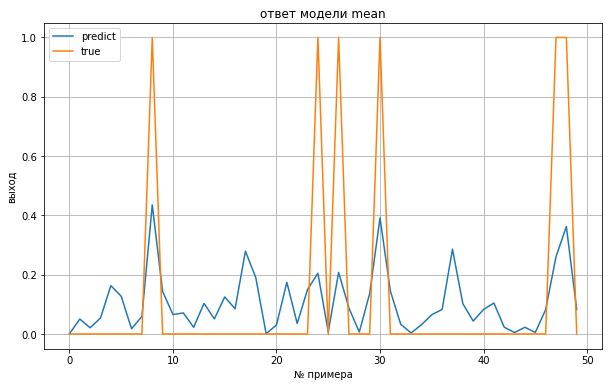

Best Threshold=0.23748647844523976, F-Score=0.670, Precision=0.603, Recall=0.755
ROC_AUC score: 0.9420123939175232


In [39]:
preds = {}
preds['mean'] = get_preds(user_embeddings, 'mean')

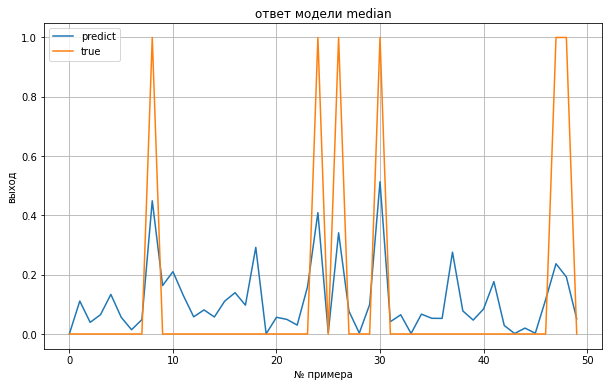

Best Threshold=0.25836196160971026, F-Score=0.725, Precision=0.681, Recall=0.775
ROC_AUC score: 0.9607571194888583


In [42]:
preds['median'] = get_preds(user_embeddings, 'median')

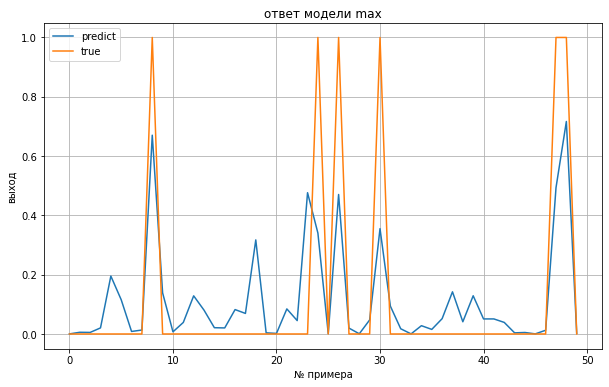

Best Threshold=0.3340039410203418, F-Score=0.798, Precision=0.815, Recall=0.783
ROC_AUC score: 0.9668522662226154


In [43]:
preds['max'] = get_preds(user_embeddings, 'max')

In [44]:
res_table = pd.DataFrame(preds.values(), columns=['f-score', 'precision', 'recall', 'roc_auc'])
res_table.insert(0, 'type', calc_types)
res_table

,type,f-score,precision,recall,roc_auc
0,mean,0.670175,0.602524,0.754941,0.942012
1,median,0.724584,0.680556,0.774704,0.960757
2,max,0.798387,0.814815,0.782609,0.966852


## Лучший результат показал max. Есть подозрение, что наилучший показатель показывает вектор с наибольшими значениями (то есть наиболее информативный).